In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
%matplotlib inline

In [23]:
import os
import json
from collections import OrderedDict
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import h5py

In [3]:
from agnfinder.tf_sampling import deep_emulator, api, run_sampler
# from agnfinder.tf_sampling.api import SamplingProblem
# from agnfinder.tf_sampling.hmc import SamplerHMC

In [4]:
from agnfinder.tf_sampling import hmc

In [5]:
# tf.enable_eager_execution()

In [6]:
os.chdir('/home/mike/repos/agnfinder')

In [7]:
params = ['mass', 'dust2', 'tage', 'tau', 'agn_disk_scaling', 'agn_eb_v', 'agn_torus_scaling']

In [9]:
checkpoint_dir = 'results/checkpoints/latest'
new_emulator = False

In [10]:
emulator = deep_emulator.get_trained_keras_emulator(deep_emulator.tf_model(), checkpoint_dir, new=new_emulator)

In [14]:
# _, _, x_test, y_test = deep_emulator.data()
# x_test = x_test.astype(np.float32)
# y_test = y_test.astype(np.float32)


In [15]:
# x_target = np.ones(7) * .5
# distance = np.sum(np.abs(x_test - x_target), axis=1)
# n_best = np.argmin(distance)
# n_best


# 1977

In [16]:
# x_test[1977]

In [20]:
param_dim = 7
n_chains = 1

In [21]:
# galaxy_n = n_best
# true_params = x_test[galaxy_n]
# true_observation = deep_emulator.denormalise_photometry(y_test[galaxy_n])

In [26]:
# galaxy_loc = 'results/emulated_sampling/latest_6000_96_random/galaxy_{}_performance.h5'.format(galaxy_n)
# galaxy_loc = 'results/emulated_sampling/latest_6000_96_random/galaxy_{}_performance.h5'.format(galaxy_n)
galaxy_n = 0
galaxy_loc = '/media/mike/beta/agnfinder_results/latest_80000_512_optimised/galaxy_{}_performance.h5'.format(galaxy_n)
assert os.path.isfile(galaxy_loc)
f = h5py.File(galaxy_loc, mode='r')
samples = f['samples'][...]
true_params = f['true_params'][...]
true_params = f['true_params'][...]
true_observation = f['true_observations'][...]



In [27]:
# optimised_start = hmc.optimised_start(emulator_fixed_scale, true_observation, param_dim, n_chains, steps=3000)
# optimised_start = fix_scale(optimised_start)
optimised_start = hmc.optimised_start(emulator, true_observation, param_dim, n_chains, steps=3000)
optimised_start = optimised_start.numpy()

TypeError: optimised_start() missing 1 required positional argument: 'n_chains'

In [16]:
optimised_df = pd.DataFrame(data=[dict(zip(params, state)) for state in optimised_start])
optimised_df['method'] = 'optimised'

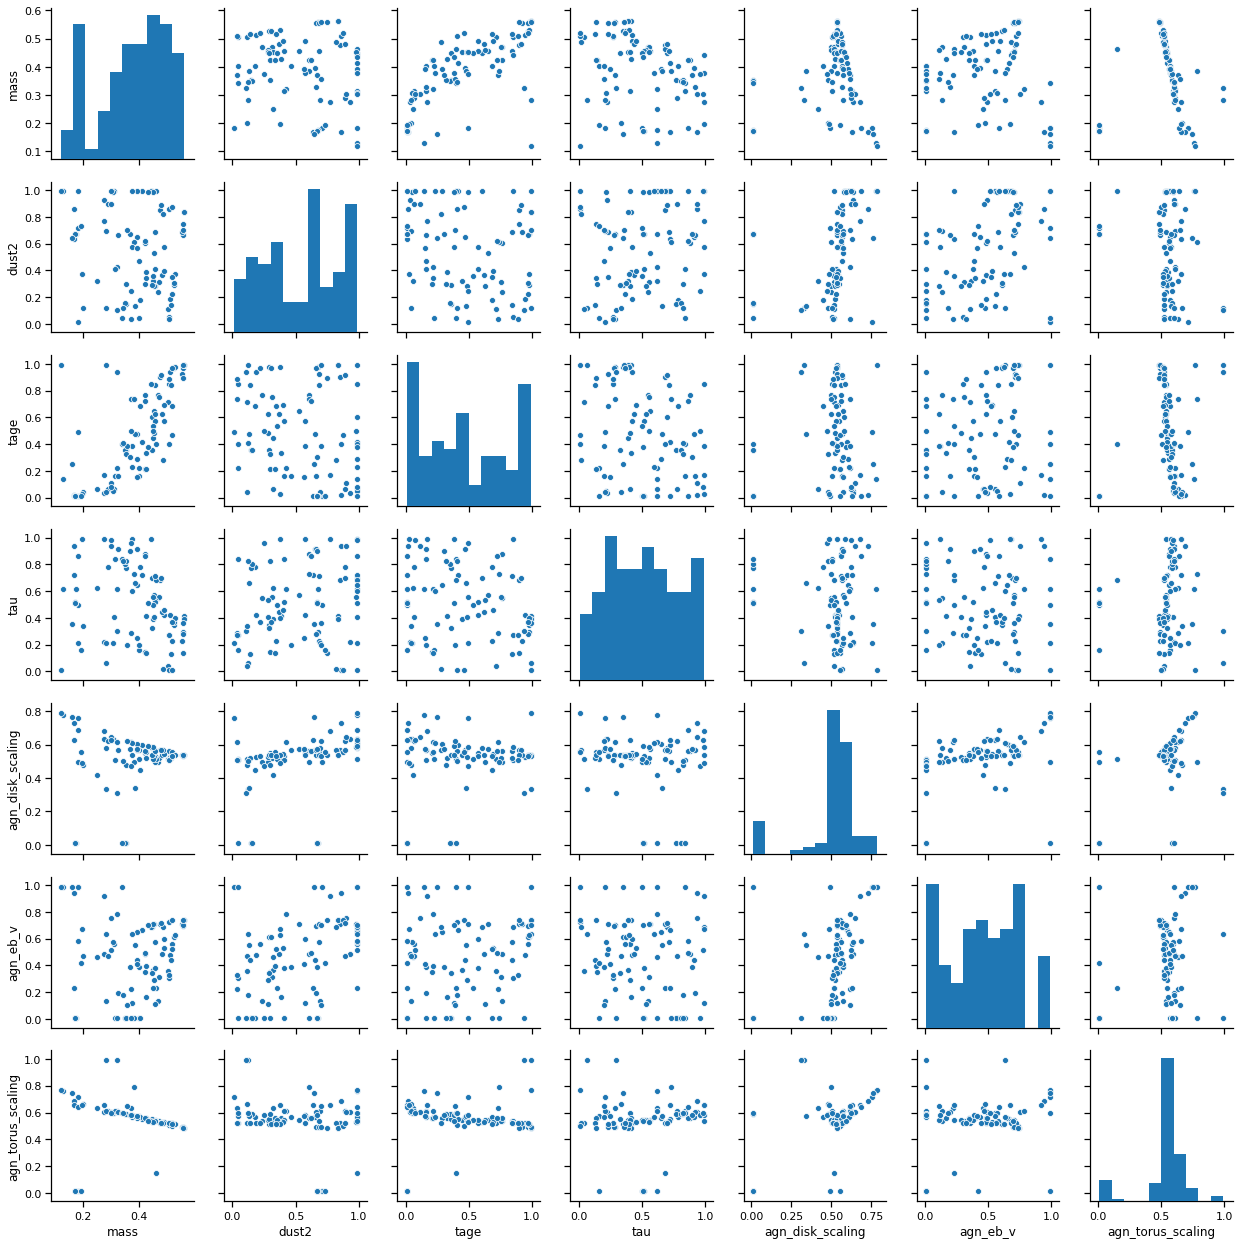

In [17]:
sns.pairplot(optimised_df)

In [18]:
random_start = hmc.many_random_starts(emulator, true_observation, param_dim, n_chains, 1000).numpy()

In [19]:
random_df = pd.DataFrame(data=[dict(zip(params, state)) for state in random_start])
random_df['method'] = 'best_random'

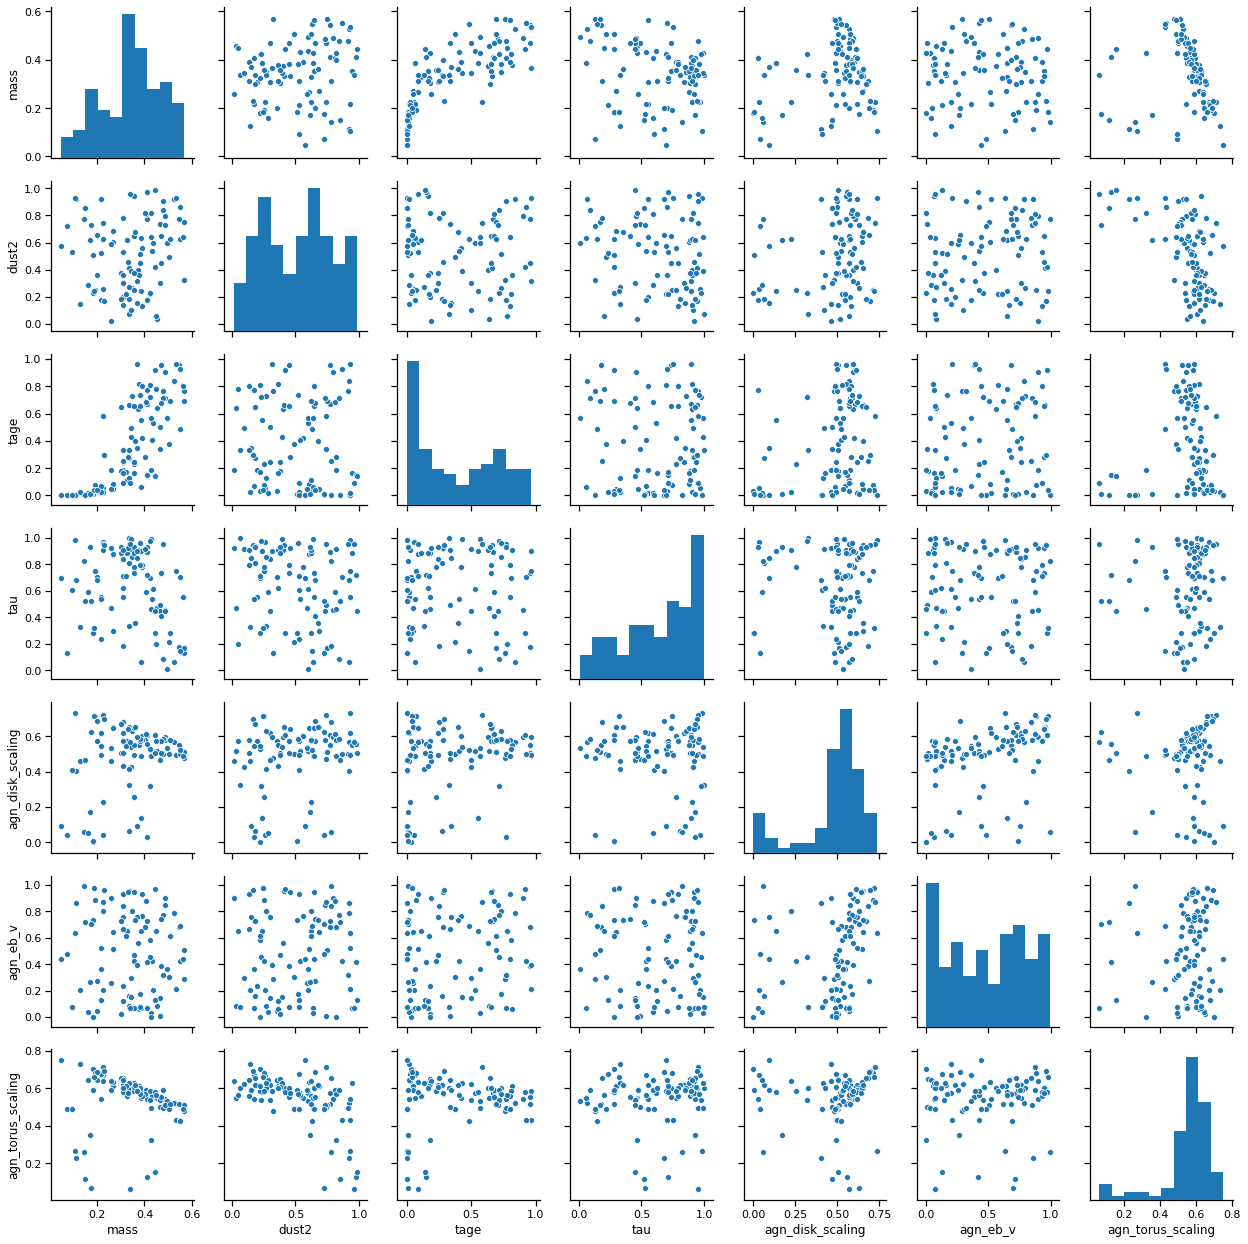

In [20]:
sns.pairplot(random_df)

In [21]:
correct_df = pd.DataFrame(data=[dict(zip(params, true_params))])
correct_df['method'] = 'correct'
correct_df.head()

rough_start = hmc.roughly_correct_start(true_params, n_chains).numpy()
rough_df = pd.DataFrame(data=[dict(zip(params, state)) for state in rough_start])
rough_df['method'] = 'roughly_correct'

In [22]:
df = pd.concat([correct_df, rough_df, random_df, optimised_df]).reset_index(drop=True)

In [23]:
true_params

array([0.44350138, 0.51174366, 0.47749552, 0.4945599 , 0.55021906,
       0.44771326, 0.5399335 ], dtype=float32)

For this galaxy where tage is very small, tau truly doesn't matter

/media/mike/Windows/linux_cache/miniconda37/envs/agnfinder/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/media/mike/Windows/linux_cache/miniconda37/envs/agnfinder/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


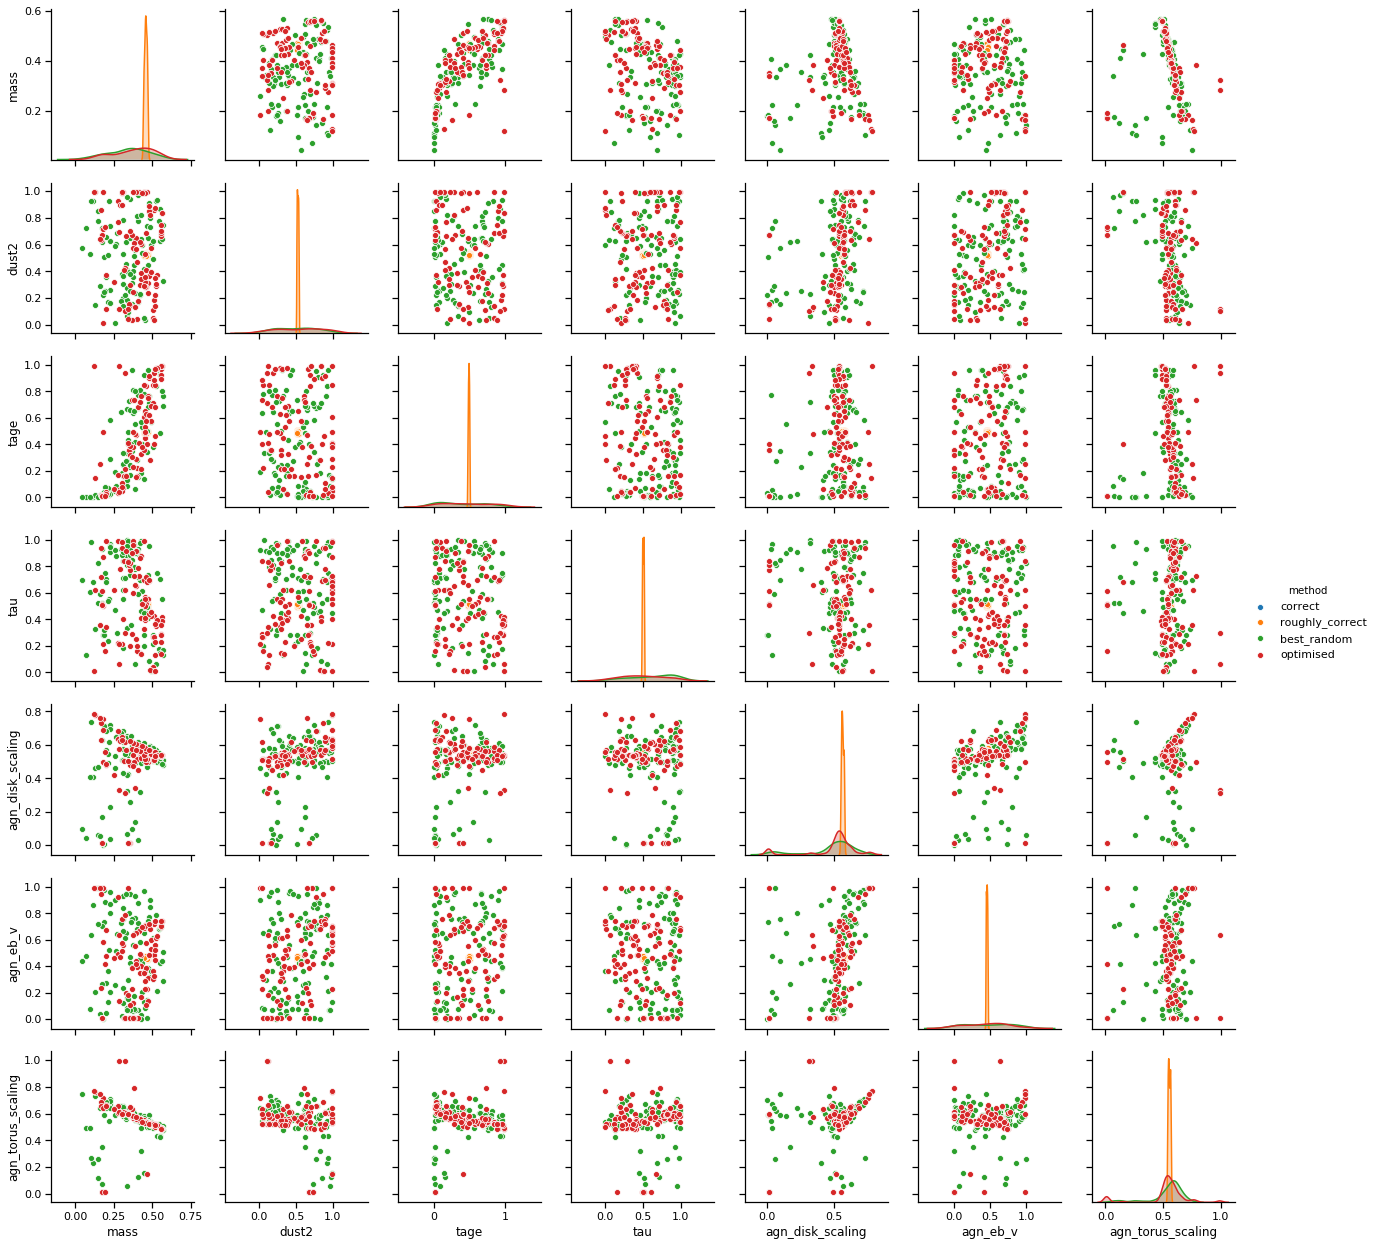

In [24]:
sns.pairplot(df, hue='method')

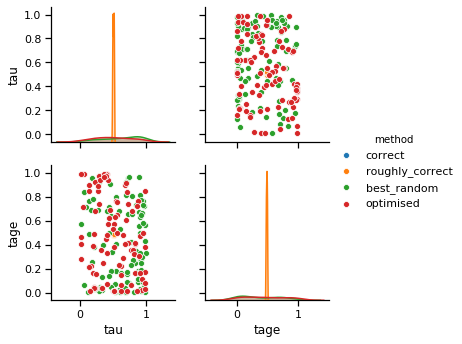

In [25]:
sns.pairplot(df[['tau', 'tage', 'method']], hue='method')

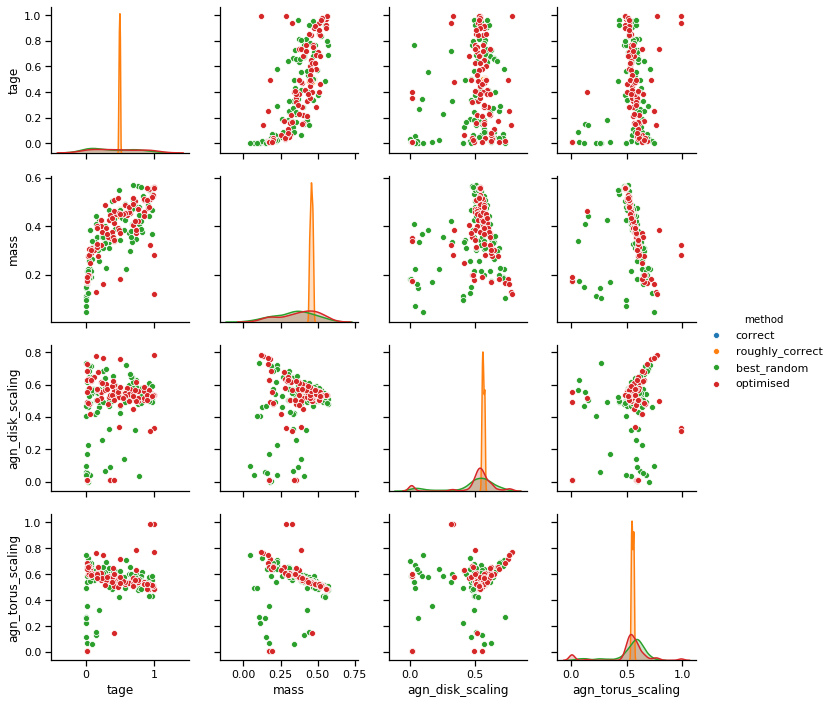

In [26]:
sns.pairplot(df[['tage', 'mass', 'agn_disk_scaling', 'agn_torus_scaling', 'method']], hue='method')

if we fix the scaling params, does it therefore fix tage/tau/dust?

In [27]:
def fix_scale(p):
    p_slices = tf.split(p, 7, axis=1)
    for scale_index in [0, 4, 6]:
        p_slices[scale_index] = tf.fill([n_chains, 1], true_params[scale_index])
    return tf.squeeze(tf.stack(p_slices, axis=1))

In [28]:
def emulator_fixed_scale(p, training):
    p_fixed = fix_scale(p)
    return emulator(p_fixed)

In [29]:
optimised_start_fixed = hmc.optimised_start(emulator_fixed_scale, true_observation, param_dim, n_chains, steps=3000)
optimised_start_fixed = optimised_start_fixed.numpy()

In [30]:
true_params

array([0.44350138, 0.51174366, 0.47749552, 0.4945599 , 0.55021906,
       0.44771326, 0.5399335 ], dtype=float32)

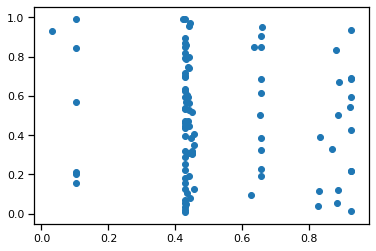

In [31]:
plt.scatter(optimised_start_fixed[:, 3], optimised_start_fixed[:, 4])

/media/mike/Windows/linux_cache/miniconda37/envs/agnfinder/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/media/mike/Windows/linux_cache/miniconda37/envs/agnfinder/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


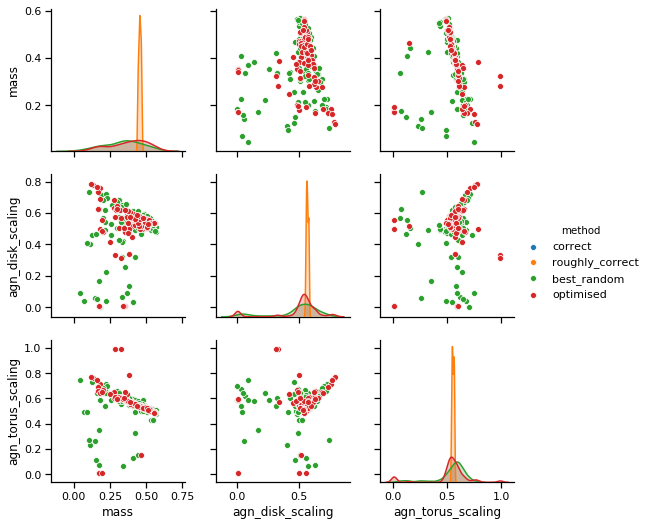

In [32]:
sns.pairplot(df[['mass', 'agn_disk_scaling', 'agn_torus_scaling', 'method']], hue='method')

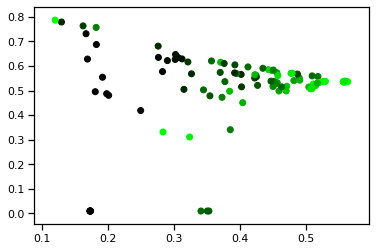

In [33]:
dfs = df[df['method']=='optimised']
c_col = 'tage'
vals = (dfs[c_col] - dfs[c_col].min()) / (dfs[c_col].max() - dfs[c_col].min())
colors = [(0, v, 0) for v in vals]
plt.scatter(dfs['mass'], dfs['agn_disk_scaling'], c=colors)

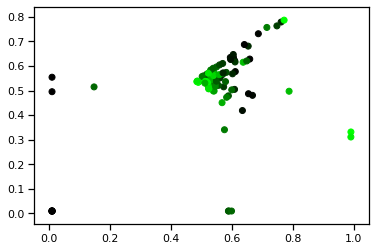

In [34]:
plt.scatter(dfs['agn_torus_scaling'], dfs['agn_disk_scaling'], c=colors)

Text(0.5, 0, 'agn_torus_scaling')

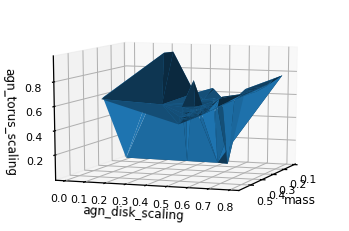

In [35]:


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(10, 20)
ax.plot_trisurf(dfs['mass'], dfs['agn_disk_scaling'], dfs['agn_torus_scaling'])
ax.set_xlabel('mass')
ax.set_ylabel('agn_disk_scaling')
ax.set_zlabel('agn_torus_scaling')

In [36]:
assert False

AssertionError: 

In [ ]:
phot_from_opt = emulator(df[df['method'] == 'optimised'][params].values).numpy()
_ = plt.plot(phot_from_opt.transpose(), alpha=.3, linestyle='', marker='+', color='r')

phot_from_actual = emulator(df[df['method'] == 'correct'][params].values).numpy()
_ = plt.plot(phot_from_actual.transpose(), linestyle='', marker='+', label='actual')
# phot_from_actual

plt.plot(-np.log10(true_observation), linestyle='', marker='+', color='k', label='obs')
plt.legend()

In [ ]:
params[2]

In [ ]:
opt = df[df['method'] == 'optimised'][params].values
plt.hist(opt[:, 2])  # but can find solutions by changing other things, presumably. Which things?

In [ ]:
opt = df[df['method'] == 'optimised'][params].values
opt[:, 2] = .1  # tage does matter
phot_from_opt = emulator(opt).numpy()
_ = plt.plot(phot_from_opt.transpose(), alpha=.3, linestyle='', marker='+', color='r')

phot_from_actual = emulator(df[df['method'] == 'correct'][params].values).numpy()
_ = plt.plot(phot_from_actual.transpose(), linestyle='', marker='+', label='actual')
# phot_from_actual

plt.plot(-np.log10(true_observation), linestyle='', marker='+', color='k', label='obs')
plt.legend()

In [ ]:
log_prob = api.get_log_prob_fn(emulator, true_observation, batch_dim=n_chains)
single_log_prob = api.get_log_prob_fn(emulator, true_observation, batch_dim=None)

In [ ]:
plt.clf()
alpha = 0.5
plt.hist(log_prob(random_start).numpy(), alpha=alpha, density=True, label='random')
plt.hist(log_prob(rough_start).numpy(), alpha=alpha, density=True, label='rough')
# plt.hist(log_prob(optimised_start).numpy(), alpha=alpha, density=True, label='optimised')
plt.axvline(single_log_prob(true_params.reshape(1, -1)).numpy(), color='k', label='actual')
plt.axvline(log_prob(optimised_start).numpy().min(), color='r', label='optimised')
plt.axvline(log_prob(optimised_start).numpy().max(), color='r')
plt.legend()

The true params are at high log prob, followed by rough and then random (as-is).
Optimised does an excellent job at finding high log prob solutions, actually finding values much better than the real ones!

In [ ]:
batch_dim = 10
random_params = tf.random.uniform([batch_dim, 7], minval=0., maxval=1.)
log_prob_many = api.get_log_prob_fn(emulator, true_observation, batch_dim=batch_dim)
%timeit log_prob_many(random_params)

In [ ]:
batch_dim = 100
random_params = tf.random.uniform([batch_dim, 7], minval=0., maxval=1.)
log_prob_many = api.get_log_prob_fn(emulator, true_observation, batch_dim=batch_dim)
%timeit log_prob_many(random_params)
log_probs = log_prob_many(random_params).numpy()
np.max(log_probs)

In [ ]:
batch_dim = 300
random_params = tf.random.uniform([batch_dim, 7], minval=0., maxval=1.)
log_prob_many = api.get_log_prob_fn(emulator, true_observation, batch_dim=batch_dim)
%timeit log_prob_many(random_params)
log_probs = log_prob_many(random_params).numpy()
np.max(log_probs)

In [ ]:
batch_dim = 1000
random_params = tf.random.uniform([batch_dim, 7], minval=0., maxval=1.)
log_prob_many = api.get_log_prob_fn(emulator, true_observation, batch_dim=batch_dim)
%timeit log_prob_many(random_params)
log_probs = log_prob_many(random_params).numpy()
np.max(log_probs)

In [ ]:
batch_dim = 5000
random_params = tf.random.uniform([batch_dim, 7], minval=0., maxval=1.)
log_prob_many = api.get_log_prob_fn(emulator, true_observation, batch_dim=batch_dim)
%timeit log_prob_many(random_params)

In [ ]:
log_probs = log_prob_many(random_params).numpy()
np.max(log_probs)
plt.hist(np.sort(log_probs)[-100:])

In [ ]:
np.sort(log_probs)